<a href="https://colab.research.google.com/github/YichengShen/cis5190-project/blob/main/cis5190_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automating Stock Trading with Reinforcement Learning**


In [ ]:
hyperparameters = {
    "turbulence_threshold":100,
    "transaction_cost":0.001
}

## **Section 1**: Environment Setup & Preparation

### 1.1 Library Installation & Imports

In [ ]:
%%capture
# install finrl library
!pip install swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install wrds

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.main import check_and_make_directories
from pprint import pprint
from stable_baselines3.common.logger import configure
import sys
sys.path.append("../FinRL")

import itertools

from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

from finrl.config_tickers import DOW_30_TICKER

### 1.2 Download Stock Data

- We focus on the constituents (30 stocks) of the Dow 30 (Dow Jones Industrial Average). The Dow 30 is a stock market index that tracks 30 large companies trading on NYSE and Nasdaq. As of Octobor 2021, it includes stocks with the following tickers.

In [ ]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


- We download historical daily stock data of the 30 stocks using Yahoo Finance API.

In [ ]:
%%capture
START_DATE = '2008-12-31'
END_DATE = '2022-10-01'

stock_df = YahooDownloader(start_date = START_DATE,
                           end_date = END_DATE,
                           ticker_list = DOW_30_TICKER).fetch_data()

### 1.3 Preprocess Stock Data

In [ ]:
stock_df['date'] = pd.to_datetime(stock_df['date'], format='%Y-%m-%d')

In [ ]:
stock_df = stock_df.sort_values(['date', 'tic'], ignore_index=True)

In [ ]:
stock_df.head()

,date,open,high,low,close,volume,tic,day
0,2008-12-31,3.070357,3.133571,3.047857,2.598352,607541200,AAPL,2
1,2008-12-31,57.110001,58.220001,57.060001,43.289665,6287200,AMGN,2
2,2008-12-31,17.969999,18.750000,17.910000,14.796392,9625600,AXP,2
3,2008-12-31,41.590000,43.049999,41.500000,32.005890,5443100,BA,2
4,2008-12-31,43.700001,45.099998,43.700001,30.214802,6277400,CAT,2


### 1.4 Download Financial Data

- This data comes from FinRL's tutorial.

In [ ]:
url = 'https://raw.githubusercontent.com/mariko-sawada/FinRL_with_fundamental_data/main/dow_30_fundamental_wrds.csv'

financial_df = pd.read_csv(url)

url_fr_df = 'https://raw.githubusercontent.com/YichengShen/cis5190-project/main/data/fr.csv'

fr_df = pd.read_csv(url_fr_df)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (16,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### 1.5 Preprocess Financial Data

- We figure out the columns containing the ticker, the date indicating quarters, and the ratios.

In [ ]:
fr_columns = ['TICKER', 'qdate', 'CAPEI', 'bm',
       'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
       'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt',
       'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'divyield', 'PEG_1yrforward', 'PEG_ltgforward']

fr_df = fr_df[fr_columns]

In [ ]:
fr_df['qdate'] = pd.to_datetime(fr_df['qdate'], format='%Y-%m-%d')

- In each quarter, there are 3 months. There might be multiple rows of data in each quarter, so we average those rows to get quarterly data.

In [ ]:
fr_df = fr_df.groupby(by=['qdate', 'TICKER']).mean()\
             .reset_index()\
             .sort_values(by=['TICKER', 'qdate'])

In [ ]:
original_fr_df = fr_df.copy()

- If there are too many null values in a column, we drop the column.

In [ ]:
num_rows = fr_df.shape[0]
null_threshold = 0.1

# If there are more null values than the threshold, we remove the column
fr_df = original_fr_df.dropna(axis='columns', thresh=int(num_rows*(1-null_threshold)))

In [ ]:
fr_df = fr_df.fillna(0)

In [ ]:
len(original_fr_df.columns)

72

In [ ]:
len(fr_df.columns.values)

58

In [ ]:
fr_df = fr_df.rename(columns={'TICKER':'tic', 'qdate':'date'})

### 1.6 Merge Stock Data with Financial Data

In [ ]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list = INDICATORS,
    use_turbulence=True)

processed_stock_df = fe.preprocess_data(stock_df)
processed_stock_df.head(5)

Successfully added technical indicators
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2008-12-31,3.070357,3.133571,3.047857,2.598352,607541200,AAPL,2,0.0,2.913038,2.448061,100.0,66.666667,100.0,2.598352,2.598352,0.0
1,2008-12-31,57.110001,58.220001,57.060001,43.289665,6287200,AMGN,2,0.0,2.913038,2.448061,100.0,66.666667,100.0,43.289665,43.289665,0.0
2,2008-12-31,17.969999,18.750000,17.910000,14.796392,9625600,AXP,2,0.0,2.913038,2.448061,100.0,66.666667,100.0,14.796392,14.796392,0.0
3,2008-12-31,41.590000,43.049999,41.500000,32.005890,5443100,BA,2,0.0,2.913038,2.448061,100.0,66.666667,100.0,32.005890,32.005890,0.0
4,2008-12-31,43.700001,45.099998,43.700001,30.214802,6277400,CAT,2,0.0,2.913038,2.448061,100.0,66.666667,100.0,30.214802,30.214802,0.0


In [ ]:
for tic_name in stock_df.tic.unique():
    if tic_name not in processed_stock_df.tic.unique():
        print(f"Missing: {tic_name}")

Missing: DOW


In [ ]:
# Generate a DataFrame with the Cartesian product of tickers and dates
all_tickers = processed_stock_df['tic'].unique().tolist()
all_dates = list(pd.date_range(processed_stock_df['date'].min(), processed_stock_df['date'].max()))
comb = list(itertools.product(all_dates, all_tickers))
full_df = pd.DataFrame(comb, columns=['date', 'tic'])

# Merge with stock data
full_df = full_df.merge(processed_stock_df, on=['date', 'tic'], how='left')

# Merge with financial data
full_df = full_df.merge(fr_df, on=['date', 'tic'], how='left')

# Sort
full_df = full_df.sort_values(['tic','date'])

# Backfill 
full_df = full_df.bfill(axis='rows')

In [ ]:
full_df.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_1yrforward,PEG_ltgforward
0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.598352,607541200.0,2.0,0.0,2.913038,...,4.832,1.703,1.703,0.034,0.015,0.000,-0.150,4.004000,-0.607667,0.036000
1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.289665,6287200.0,2.0,0.0,2.913038,...,3.200,0.508,0.736,0.202,0.005,0.000,-0.050,2.419667,6.997000,1.091667
2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.796392,9625600.0,2.0,0.0,2.913038,...,0.820,0.561,2.696,0.000,0.000,0.191,-0.042,1.668000,-0.102333,0.667333
3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005890,5443100.0,2.0,0.0,2.913038,...,9.495,10.765,0.000,0.062,0.000,0.255,0.054,0.000000,0.318333,1.191333
4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.214802,6277400.0,2.0,0.0,2.913038,...,8.124,1.743,8.432,0.034,0.000,0.177,-0.020,2.843333,-0.083333,0.561667
5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.913038,...,15.582,1.568,1.603,0.092,0.041,0.000,-0.145,6.932333,1.801667,2.989667
6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.575117,37513700.0,2.0,0.0,2.913038,...,16.665,0.959,1.136,0.140,0.000,0.000,-0.085,2.864667,-0.780333,1.470000
7,2008-12-31,CVX,72.900002,74.629997,72.900002,42.594913,9964300.0,2.0,0.0,2.913038,...,10.705,2.737,2.944,0.003,0.000,0.000,-0.037,1.320667,-0.100333,0.665333
8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538345,9012100.0,2.0,0.0,2.913038,...,5.404,0.815,1.151,0.000,0.077,0.000,-0.016,1.003667,-0.387000,1.139667
9,2008-12-31,GS,82.239998,86.150002,81.120003,67.842331,14894100.0,2.0,0.0,2.913038,...,-0.287,0.213,0.832,0.000,0.000,0.204,0.000,1.624000,0.194667,3.055667


In [ ]:
full_df.columns.values

array(['date', 'tic', 'open', 'high', 'low', 'close', 'volume', 'day',
       'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
       'close_30_sma', 'close_60_sma', 'turbulence', 'CAPEI', 'bm', 'evm',
       'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr',
       'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'debt_at',
       'debt_ebitda', 'short_debt', 'lt_debt', 'cash_debt', 'fcf_ocf',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'intcov', 'intcov_ratio', 'at_turn', 'rect_turn', 'pay_turn',
       'sale_invcap', 'sale_equity', 'rd_sale', 'adv_sale', 'staff_sale',
       'accrual', 'ptb', 'PEG_1yrforward', 'PEG_ltgforward'], dtype=object)

In [ ]:
len(full_df.columns.values)

73

In [ ]:
len(full_df.tic.unique())

29

## 5.1 Data Split
- Training data period: 2009-01-01 to 2019-01-01
- Trade data period: 2019-01-01 to 2020-12-31

In [ ]:
train_data = data_split(full_df, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(full_df, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(trade_data))

69542
12354


In [ ]:
train_data.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_1yrforward,PEG_ltgforward
0,2014-01-06,AAPL,19.194643,19.528570,19.057142,17.125866,412610800.0,0.0,0.084480,18.054952,...,4.743,1.247,1.417,0.029,0.006,0.000,-0.079,3.996000,0.049000,0.040333
0,2014-01-06,AMGN,114.470001,114.919998,113.120003,89.227142,2838100.0,0.0,0.190122,91.220101,...,2.524,0.384,0.870,0.223,0.000,0.000,-0.028,4.023000,3.011667,2.564333
0,2014-01-06,AXP,89.699997,90.250000,89.379997,78.685356,2844700.0,0.0,1.514973,80.592795,...,0.435,0.498,1.809,0.000,0.000,0.177,0.008,4.828667,1.644333,1.833667
0,2014-01-06,BA,139.399994,139.759995,137.800003,118.295074,4196500.0,0.0,1.134662,118.791166,...,7.375,4.463,7.691,0.036,0.000,0.000,-0.047,6.387333,2.712333,2.130000
0,2014-01-06,CAT,90.190002,90.300003,88.379997,68.561165,5233900.0,0.0,1.059910,71.574041,...,5.432,1.222,2.899,0.036,0.000,0.197,-0.079,3.193667,2.291667,1.379333


In [ ]:
train_data.columns.values

array(['date', 'tic', 'open', 'high', 'low', 'close', 'volume', 'day',
       'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
       'close_30_sma', 'close_60_sma', 'turbulence', 'CAPEI', 'bm', 'evm',
       'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr',
       'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'debt_at',
       'debt_ebitda', 'short_debt', 'lt_debt', 'cash_debt', 'fcf_ocf',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'intcov', 'intcov_ratio', 'at_turn', 'rect_turn', 'pay_turn',
       'sale_invcap', 'sale_equity', 'rd_sale', 'adv_sale', 'staff_sale',
       'accrual', 'ptb', 'PEG_1yrforward', 'PEG_ltgforward'], dtype=object)

In [ ]:
trade_data.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_1yrforward,PEG_ltgforward
0,2020-08-01,AAPL,108.199997,111.637497,107.892502,107.266502,308151200.0,0.0,3.166571,103.299576,...,3.580,1.592,4.201,0.068,0.000,0.000,-0.070,31.659333,1.845000,3.061667
0,2020-08-01,AMGN,244.850006,249.020004,244.529999,229.484116,1853900.0,0.0,1.846089,242.161453,...,2.457,0.600,2.451,0.172,0.034,0.000,-0.056,11.993333,2.047667,3.108667
0,2020-08-01,AXP,93.309998,94.400002,92.440002,90.898560,2869000.0,0.0,-0.468254,95.370092,...,0.387,0.588,1.867,0.000,0.000,0.126,-0.010,4.366000,-0.493333,3.361000
0,2020-08-01,BA,156.509995,163.580002,153.410004,162.270004,38520500.0,0.0,-4.022719,188.746996,...,4.776,1.963,0.000,0.041,0.000,0.000,0.083,0.000000,-0.160000,0.000000
0,2020-08-01,CAT,132.300003,133.000000,131.100006,125.353134,2851100.0,0.0,2.364296,136.737679,...,4.942,1.080,3.039,0.033,0.000,0.000,-0.044,6.522667,-0.589667,-12.187000


## 5.2 Set up the training environment

In [ ]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots=False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index + 1] > 0:
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct)
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct)
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if self.state[index + 1] > 0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // self.state[index + 1]
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1] * buy_num_shares * (1 + self.buy_cost_pct)
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.initial_amount
            )
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252 ** 0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}

        else:

            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + [0] * self.stock_dim
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    [
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ],
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
            )
        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

## Name ratio list

In [ ]:
ratio_list = train_data.columns[7:].to_list()

stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 1973


## [WIP] Visualize turbulence histogram

In [ ]:
data_risk_indicator = full_df[(full_df.date<TRAIN_END_DATE) & (full_df.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])
insample_risk_indicator.turbulence.describe()

count    2398.000000
mean       39.386152
std        51.852386
min         2.490526
25%        17.205226
50%        25.619987
75%        42.246510
max       652.506982
Name: turbulence, dtype: float64

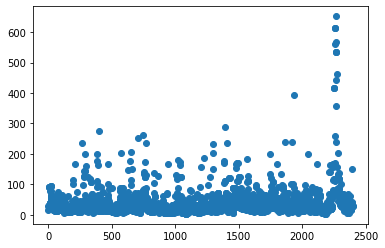

In [ ]:
%matplotlib inline
# insample_risk_indicator["turbulence"].to_list()
# np.arange(len(insample_risk_indicator.index))
plt.scatter(np.arange(len(insample_risk_indicator.index)), insample_risk_indicator["turbulence"].to_list()) # / len(insample_risk_indicator.index)
# plt.xaxis("")
plt.show()

In [ ]:
# num_less_than = len(insample_risk_indicator[insample_risk_indicator["turbulence"] < 70])
# num_less_than / 3651

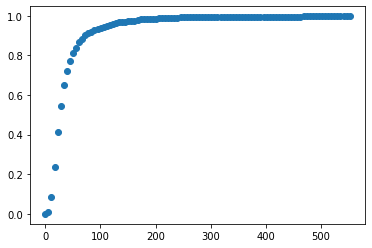

In [ ]:
thresh_choices = np.linspace(0, 552, 100)
plt.scatter(thresh_choices,
            [len(insample_risk_indicator[insample_risk_indicator["turbulence"] < choice]) / len(insample_risk_indicator) for choice in thresh_choices])

In [ ]:
insample_risk_indicator.turbulence.quantile(0.994)

379.5702977819486

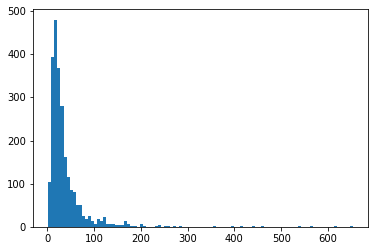

In [ ]:
_junk = plt.hist(insample_risk_indicator["turbulence"], bins=100)

In [ ]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": hyperparameters["transaction_cost"],
    "sell_cost_pct": hyperparameters["transaction_cost"],
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "turbulence_threshold": hyperparameters["turbulence_threshold"]
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)
e_trade_gym.seed(0)

## Environment for Training



In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
# Set up the agent using DRLAgent() class using the environment created in the previous part
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

### Model 1: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

### Model 3: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None

### Model 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=30000) if if_using_sac else None

------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 30          |
|    time_elapsed    | 312         |
|    total_timesteps | 9592        |
| train/             |             |
|    actor_loss      | 305         |
|    critic_loss     | 753         |
|    ent_coef        | 0.0839      |
|    ent_coef_loss   | -66.9       |
|    learning_rate   | 0.0001      |
|    n_updates       | 9491        |
|    reward          | -0.69625485 |
------------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 30        |
|    time_elapsed    | 626       |
|    total_timesteps | 19184     |
| train/             |           |
|    actor_loss      | 268       |
|    critic_loss     | 1.43e+03  |
|    ent_coef        | 0.0327    |
|    ent_coef_loss   | -80.1     |
|    learning_rate   | 0.0001    |
|    n_updates       | 19

## Trading
Assume that we have $1,000,000 initial capital at TEST_START_DATE. We use the DDPG model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
trade_data = data_split(full_df, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTradingEnv(df = trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade_data.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_1yrforward,PEG_ltgforward
0,2020-08-01,AAPL,108.199997,111.637497,107.892502,107.266502,308151200.0,0.0,3.166571,103.299576,...,3.580,1.592,4.201,0.068,0.000,0.000,-0.070,31.659333,1.845000,3.061667
0,2020-08-01,AMGN,244.850006,249.020004,244.529999,229.484116,1853900.0,0.0,1.846089,242.161453,...,2.457,0.600,2.451,0.172,0.034,0.000,-0.056,11.993333,2.047667,3.108667
0,2020-08-01,AXP,93.309998,94.400002,92.440002,90.898560,2869000.0,0.0,-0.468254,95.370092,...,0.387,0.588,1.867,0.000,0.000,0.126,-0.010,4.366000,-0.493333,3.361000
0,2020-08-01,BA,156.509995,163.580002,153.410004,162.270004,38520500.0,0.0,-4.022719,188.746996,...,4.776,1.963,0.000,0.041,0.000,0.000,0.083,0.000000,-0.160000,0.000000
0,2020-08-01,CAT,132.300003,133.000000,131.100006,125.353134,2851100.0,0.0,2.364296,136.737679,...,4.942,1.080,3.039,0.033,0.000,0.000,-0.044,6.522667,-0.589667,-12.187000


In [ ]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else [None, None]

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else [None, None]

df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else [None, None]

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else [None, None]

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else [None, None]

hit end!


In [ ]:
# df_account_value_ppo.shape
# df_account_value_ddpg.shape
# df_account_value_a2c.shape
# df_account_value_td3.shape
# df_account_value_sac.shape

In [ ]:
# df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
# df_account_value_a2c.tail()
# df_account_value_td3.tail()
# df_account_value_sac.tail()

In [ ]:
# df_actions_ppo.head()
# df_actions_ddpg.head()
# df_actions_a2c.head()
# df_actions_td3.head()
# df_actions_sac.head()

In [ ]:
df_account_value_sac.to_csv("./"+config.RESULTS_DIR+"/df_account_value_sac_"+now+'.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

if if_using_ppo:
  print("\n ppo:")
  perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
  perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
  perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

if if_using_ddpg:
  print("\n ddpg:")
  perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
  perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
  perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

if if_using_a2c:
  print("\n a2c:")
  perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
  perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
  perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

if if_using_td3:
  print("\n atd3:")
  perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
  perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
  perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

if if_using_sac:
  print("\n sac:")
  perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
  perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
  perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

==============Get Backtest Results===========

 sac:
Annual return          0.148457
Cumulative returns     0.263637
Annual volatility      0.113456
Sharpe ratio           1.279875
Calmar ratio           2.147022
Stability              0.944183
Max drawdown          -0.069145
Omega ratio            1.300778
Sortino ratio          1.880154
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.106799
Daily value at risk   -0.013718
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (294, 8)
Annual return          0.226750
Cumulative returns     0.269255
Annual volatility      0.139601
Sharpe ratio           1.539212
Calmar ratio           2.538976
Stability              0.915926
Max drawdown          -0.089308
Omega ratio            1.294292
Sortino ratio          2.240389
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.995019
Daily value at risk   -0.016735
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (294, 8)


Start date,2020-08-01
End date,2021-09-30
Total months,20
,Backtest
Annual return,14.846%
Cumulative returns,26.364%
Annual volatility,11.346%
Sharpe ratio,1.28
Calmar ratio,2.15
Stability,0.94
Max drawdown,-6.915%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.91,2020-09-02,2020-10-28,2020-11-05,47
1,5.38,2021-09-02,2021-09-30,NaT,NaN
2,4.30,2021-05-10,2021-06-18,2021-07-02,40
3,3.72,2021-02-24,2021-03-04,2021-03-10,11
4,3.62,2021-01-08,2021-01-29,2021-02-09,23


Stress Events,mean,min,max
New Normal,0.06%,-3.15%,2.98%


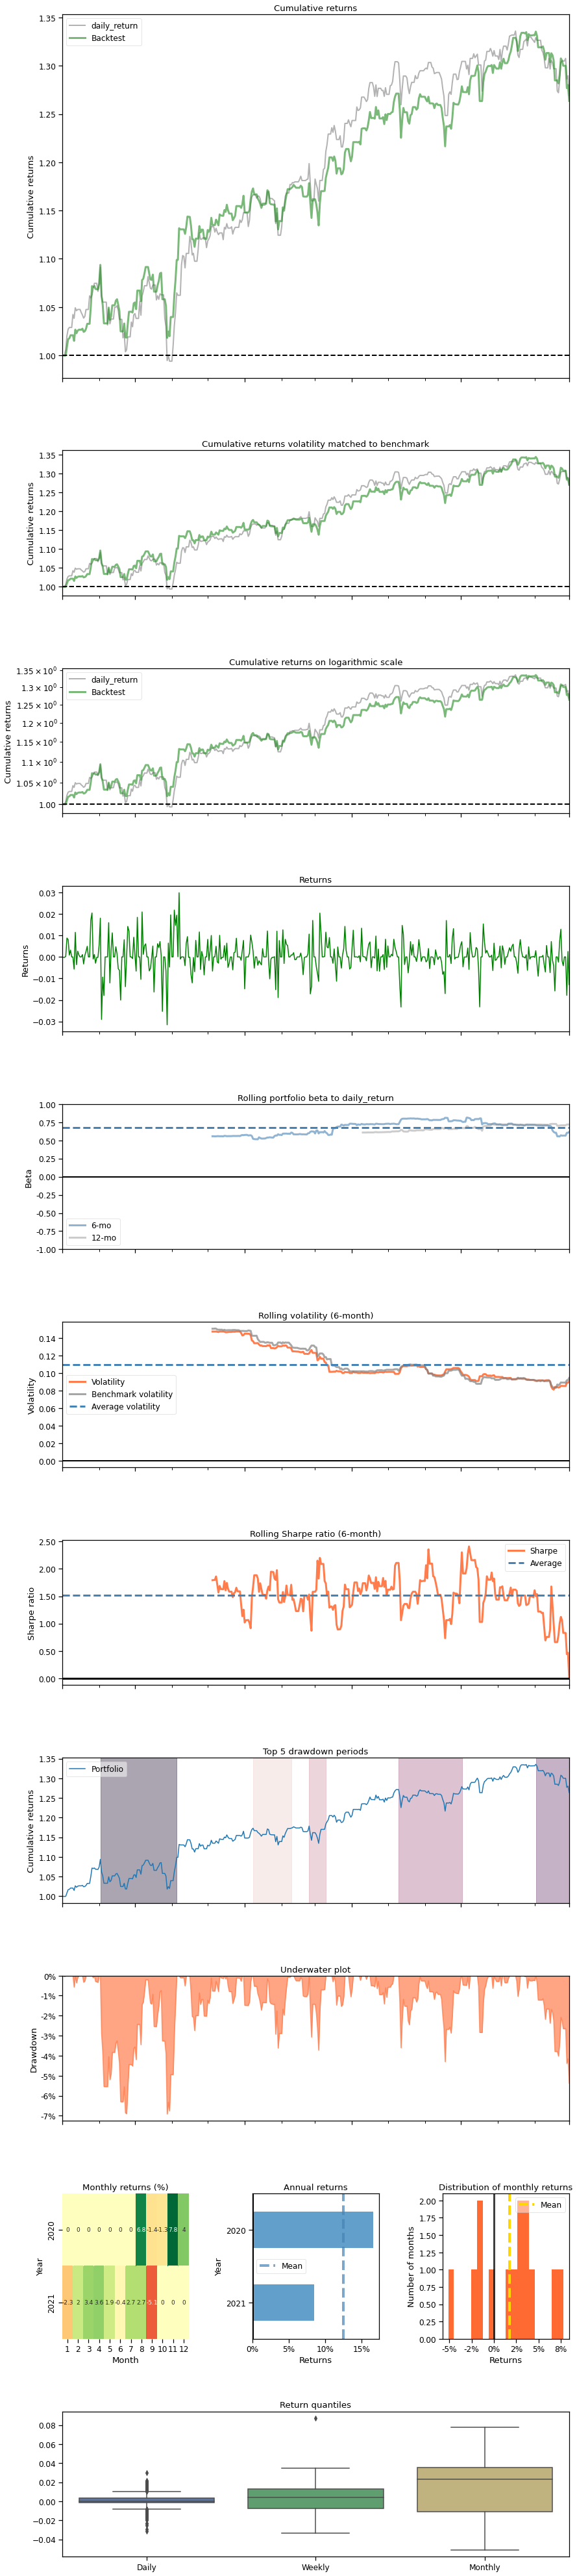

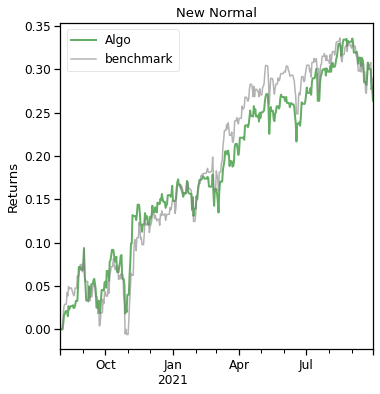

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

if if_using_ppo:
  backtest_plot(df_account_value_ppo, 
              baseline_ticker = '^DJI', 
              baseline_start = TEST_START_DATE,
              baseline_end = TEST_END_DATE)

if if_using_ddpg:
  backtest_plot(df_account_value_ddpg, 
              baseline_ticker = '^DJI', 
              baseline_start = TEST_START_DATE,
              baseline_end = TEST_END_DATE)

if if_using_a2c:
  backtest_plot(df_account_value_a2c, 
              baseline_ticker = '^DJI', 
              baseline_start = TEST_START_DATE,
              baseline_end = TEST_END_DATE)

if if_using_td3:
  backtest_plot(df_account_value_td3, 
              baseline_ticker = '^DJI', 
              baseline_start = TEST_START_DATE,
              baseline_end = TEST_END_DATE)

if if_using_sac:
  backtest_plot(df_account_value_sac, 
              baseline_ticker = '^DJI', 
              baseline_start = TEST_START_DATE,
              baseline_end = TEST_END_DATE)